In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score



Data loaded successfully. Shape: (395, 33)

First 5 rows:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  ...  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher  ...   
1     GP   F   17       U     GT3       T     1     1  at_home     other  ...   
2     GP   F   15       U     LE3       T     1     1  at_home     other  ...   
3     GP   F   15       U     GT3       T     4     2   health  services  ...   
4     GP   F   16       U     GT3       T     3     3    other     other  ...   

  famrel freetime  goout  Dalc  Walc health absences  G1  G2  G3  
0      4        3      4     1     1      3        6   5   6   6  
1      5        3      3     1     1      3        4   5   5   6  
2      4        3      2     2     3      3       10   7   8  10  
3      3        2      2     1     1      5        2  15  14  15  
4      4        3      2     1     2      5        4   6  10  10  

[5 rows x 33 columns]

Data Info:
<class 'pandas.cor

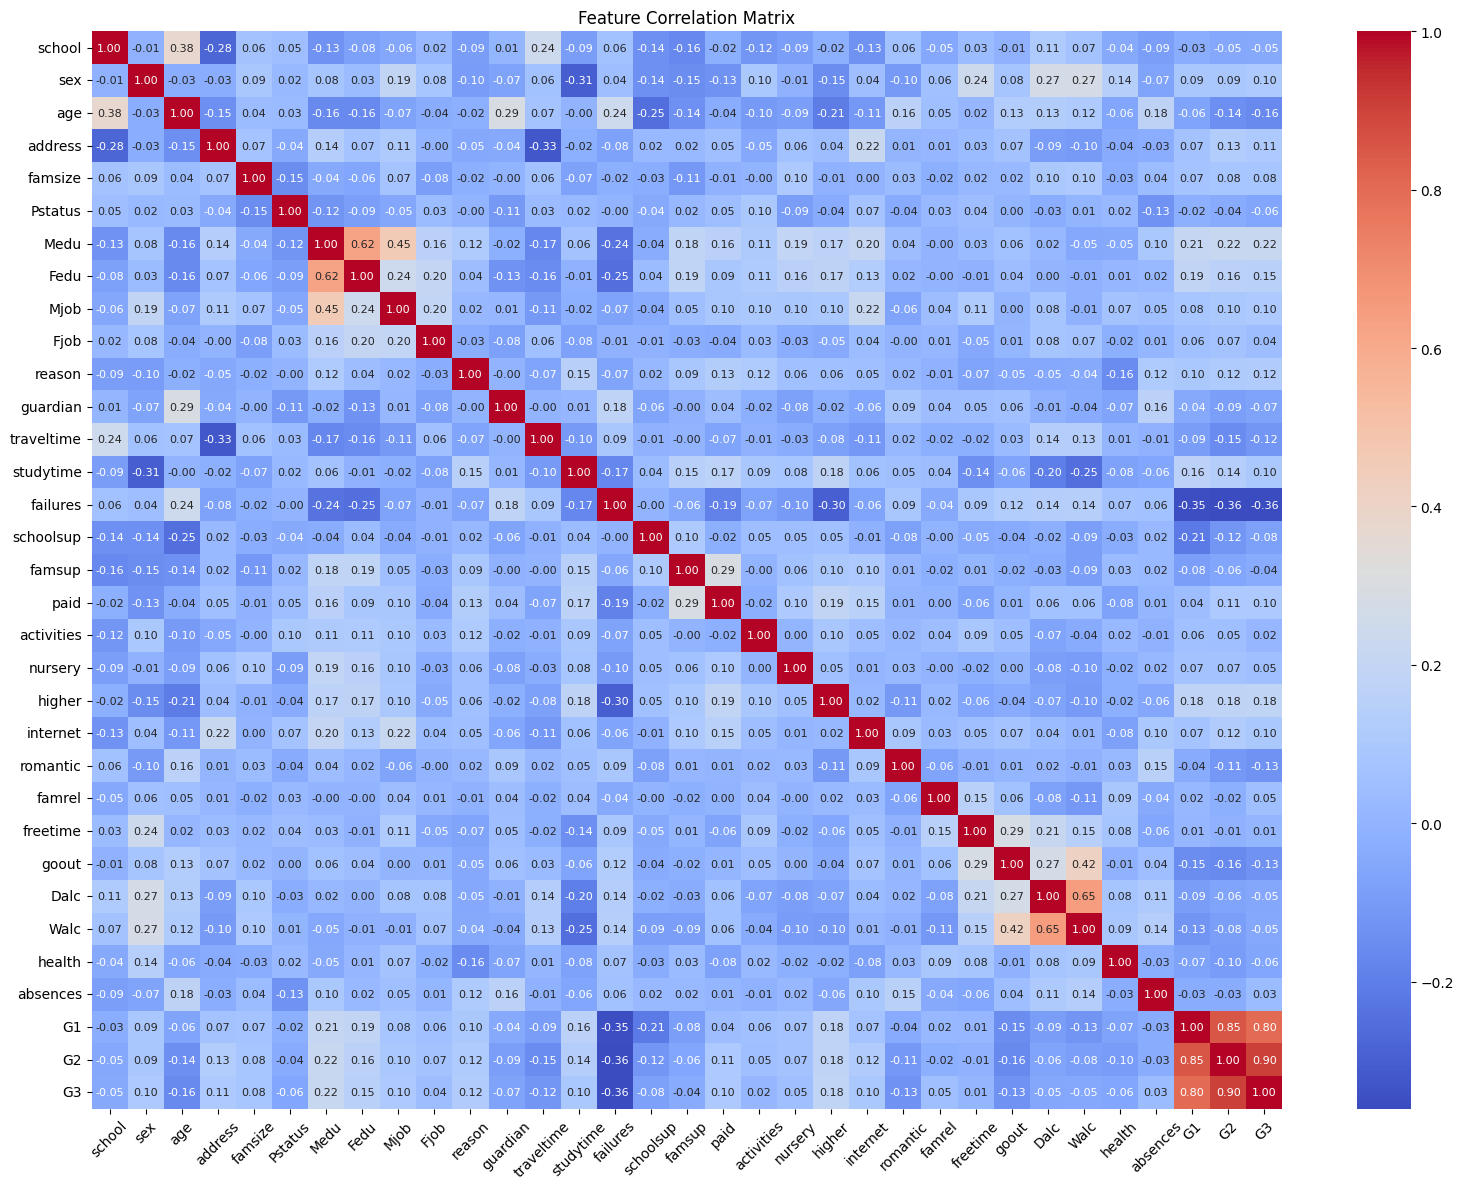

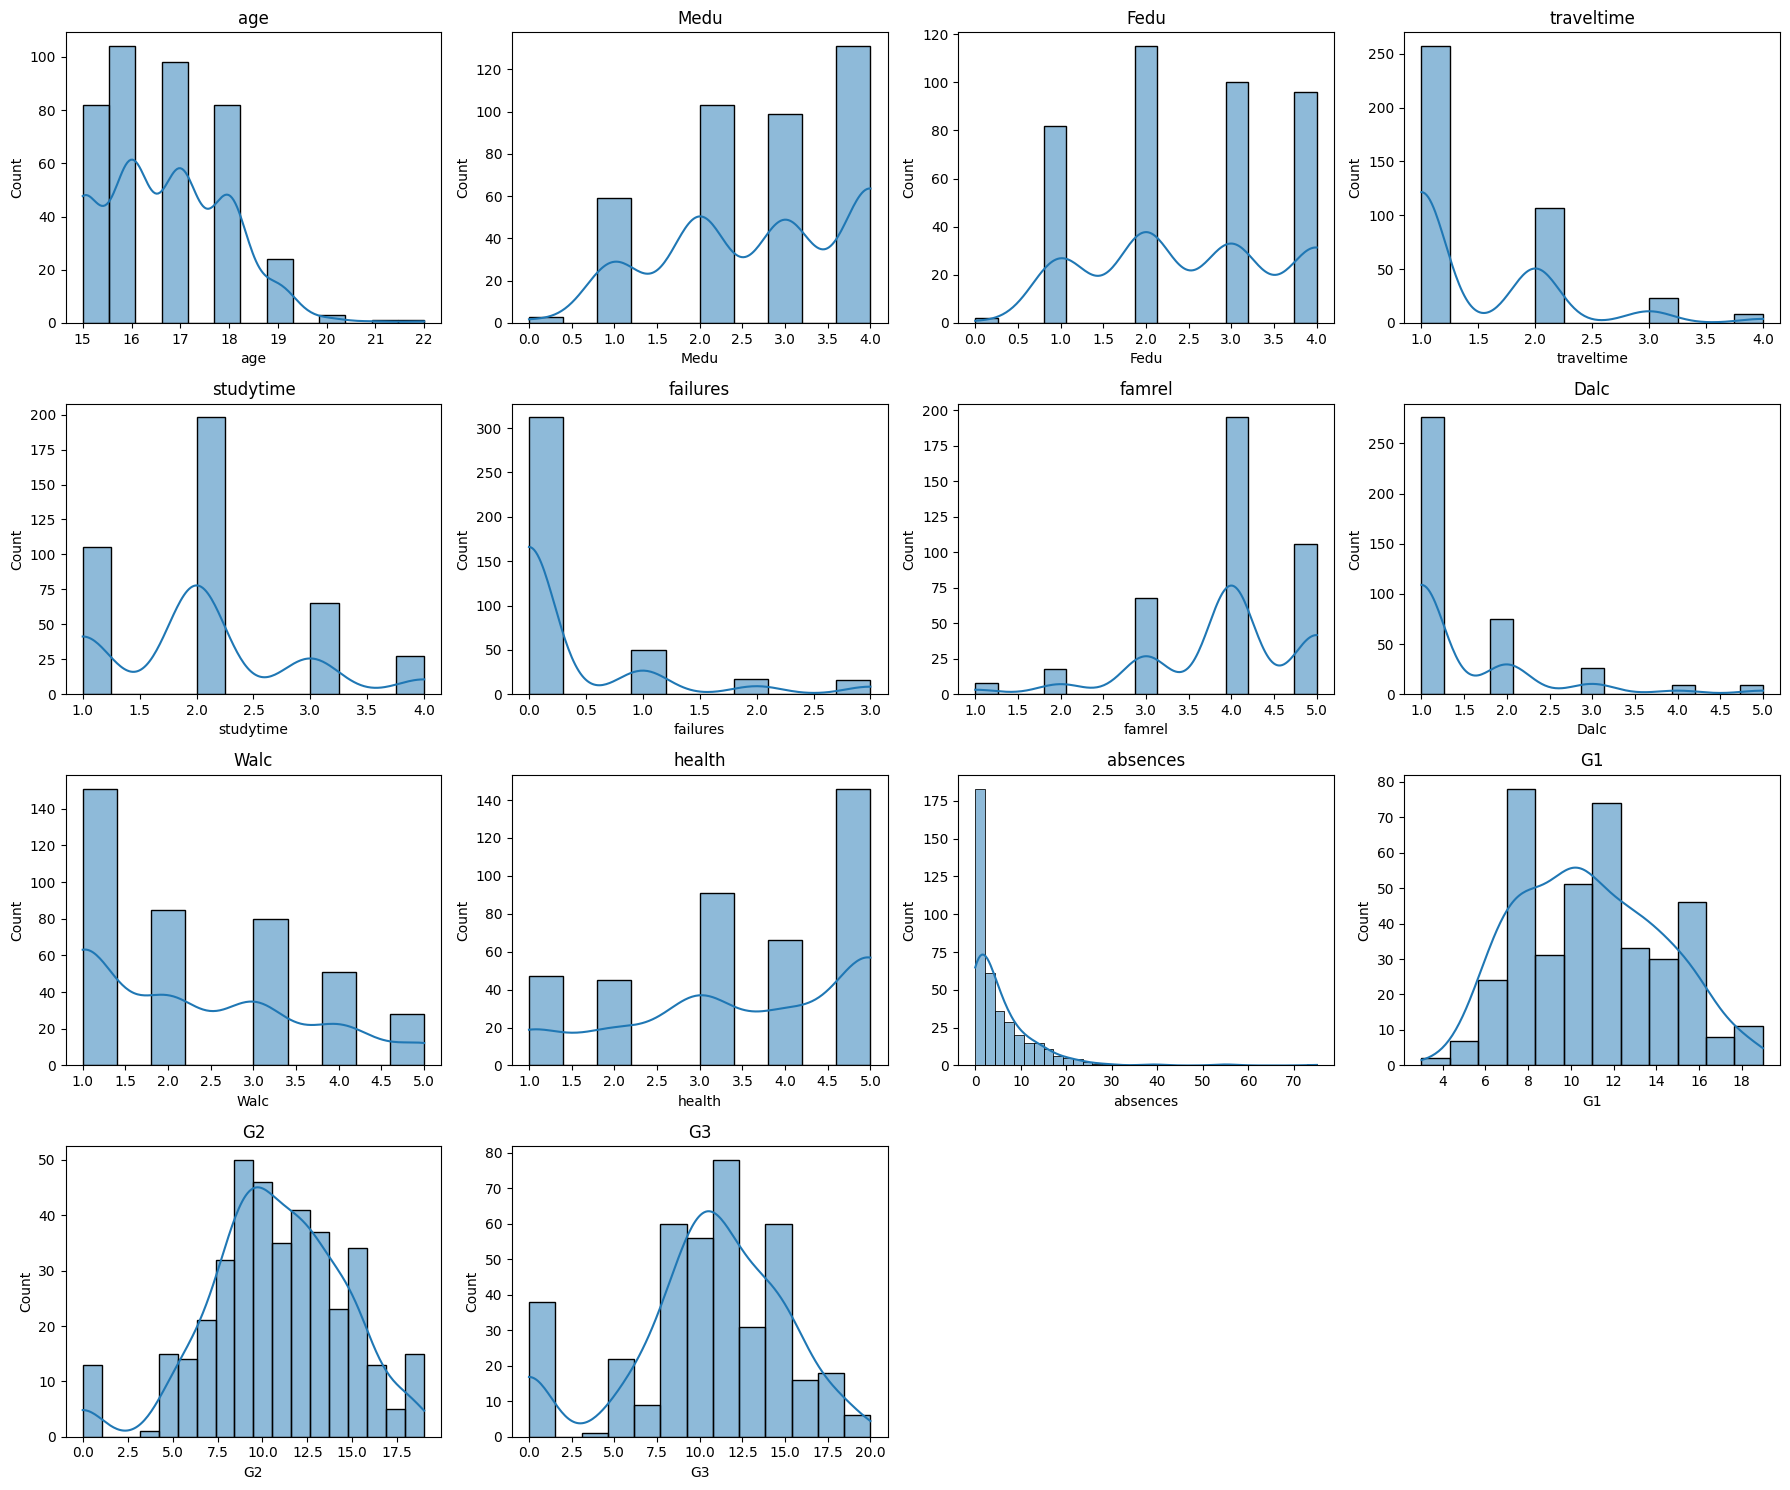

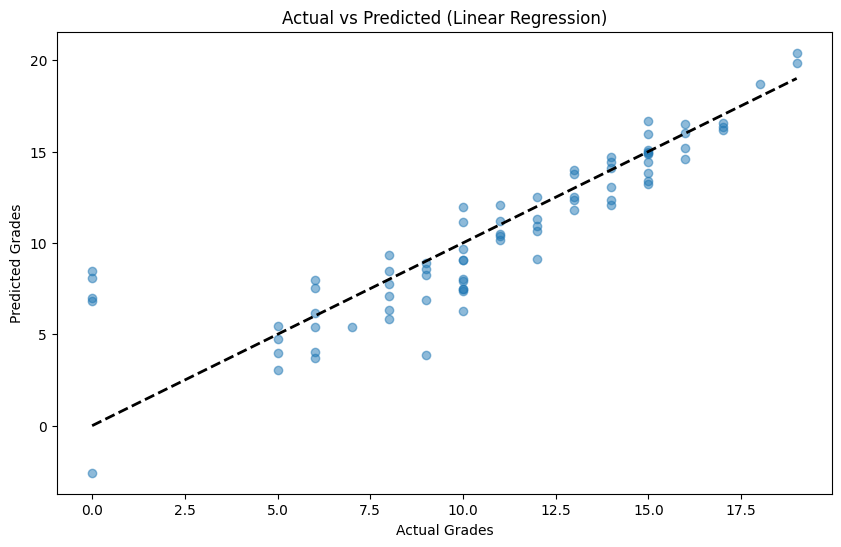

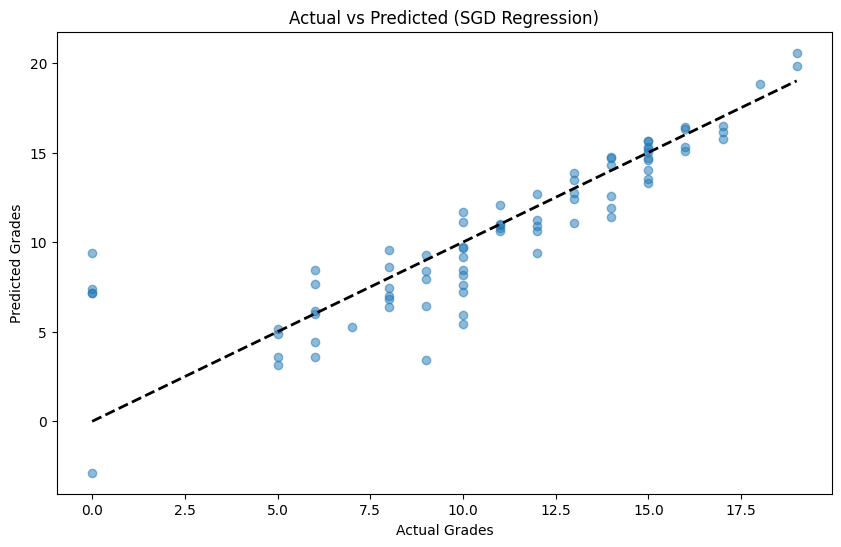


Model Performance Comparison:

Linear Regression:
  MSE: 5.03
  RMSE: 2.24
  R2 Score: 0.75

SGD Regression:
  MSE: 5.51
  RMSE: 2.35
  R2 Score: 0.73

Decision Tree:
  MSE: 5.61
  RMSE: 2.37
  R2 Score: 0.73

Random Forest:
  MSE: 3.51
  RMSE: 1.87
  R2 Score: 0.83


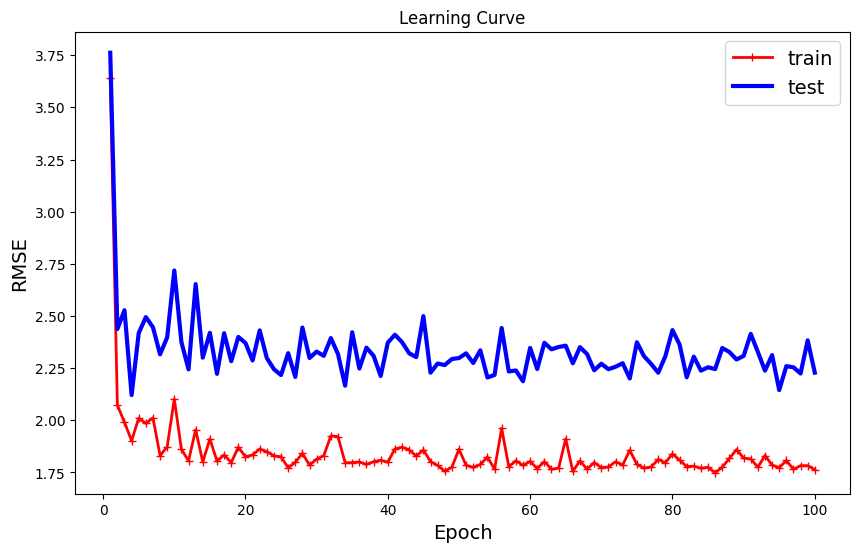

Error saving model: name 'joblib' is not defined


In [ ]:
def load_and_prepare_data(filepath='student-mat.csv'):
    """Load and prepare the dataset"""
    try:
        # Load data
        df = pd.read_csv(filepath, delimiter=';')
        print("Data loaded successfully. Shape:", df.shape)

        # Data Exploration
        print("\nFirst 5 rows:")
        print(df.head())
        print("\nData Info:")
        print(df.info())
        print("\nDescriptive Statistics:")
        print(df.describe())

        return df
    except Exception as e:
        print(f"Error loading data: {e}")
        return None

def visualize_data(df):
    """Create visualizations of the data"""
    try:
        # Create a copy for visualization to avoid modifying original
        df_viz = df.copy()

        # Encode categorical variables for correlation matrix
        categorical_cols = df_viz.select_dtypes(include=['object']).columns
        le = LabelEncoder()
        for col in categorical_cols:
            df_viz[col] = le.fit_transform(df_viz[col])

        # Correlation matrix
        plt.figure(figsize=(16, 12))
        sns.heatmap(df_viz.corr(), annot=True, cmap='coolwarm', fmt='.2f',
                   annot_kws={'size': 8})
        plt.xticks(rotation=45)
        plt.yticks(rotation=0)
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        plt.show()

        # Distributions of key features
        numeric_features = ['age', 'Medu', 'Fedu', 'traveltime', 'studytime',
                          'failures', 'famrel', 'Dalc', 'Walc', 'health',
                          'absences', 'G1', 'G2', 'G3']

        plt.figure(figsize=(18, 15))
        for i, feature in enumerate(numeric_features):
            plt.subplot(4, 4, i+1)
            sns.histplot(df[feature], kde=True)
            plt.title(feature)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error in visualization: {e}")

def preprocess_data(df, keep_previous_grades=True):
    """Preprocess data for modeling"""
    try:
        # Encode categorical variables
        categorical_cols = df.select_dtypes(include=['object']).columns
        le = LabelEncoder()
        for col in categorical_cols:
            df[col] = le.fit_transform(df[col])

        # Optionally drop previous grades
        if not keep_previous_grades:
            df = df.drop(['G1', 'G2'], axis=1)

        # Split data
        X = df.drop(['G3'], axis=1)
        y = df['G3']
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42)

        # Standardize data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        return X_train_scaled, X_test_scaled, y_train, y_test, scaler
    except Exception as e:
        print(f"Error in preprocessing: {e}")
        return None, None, None, None, None

def train_and_evaluate_models(X_train, X_test, y_train, y_test):
    """Train and evaluate different models"""
    models = {
        "Linear Regression": LinearRegression(),
        "SGD Regression": SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1),
        "Decision Tree": DecisionTreeRegressor(random_state=42),
        "Random Forest": RandomForestRegressor(random_state=42)
    }

    results = {}

    for name, model in models.items():
        try:
            # Train model
            model.fit(X_train, y_train)

            # Make predictions
            y_pred = model.predict(X_test)

            # Calculate metrics
            mse = mean_squared_error(y_test, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_test, y_pred)

            results[name] = {
                'model': model,
                'mse': mse,
                'rmse': rmse,
                'r2': r2
            }

            # Plot predictions vs actual for linear models
            if 'Regression' in name:
                plt.figure(figsize=(10, 6))
                plt.scatter(y_test, y_pred, alpha=0.5)
                plt.plot([y_test.min(), y_test.max()],
                        [y_test.min(), y_test.max()],
                        'k--', lw=2)
                plt.xlabel('Actual Grades')
                plt.ylabel('Predicted Grades')
                plt.title(f'Actual vs Predicted ({name})')
                plt.show()

        except Exception as e:
            print(f"Error with {name}: {e}")

    return results

def plot_learning_curve(model, X_train, y_train, X_test, y_test, epochs=100):
    """Plot learning curve for iterative models"""
    try:
        train_errors, test_errors = [], []

        for epoch in range(1, epochs+1):
            model.partial_fit(X_train, y_train)
            y_train_pred = model.predict(X_train)
            y_test_pred = model.predict(X_test)
            train_errors.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
            test_errors.append(np.sqrt(mean_squared_error(y_test, y_test_pred)))

        plt.figure(figsize=(10, 6))
        plt.plot(range(1, epochs+1), train_errors, "r-+", linewidth=2, label="train")
        plt.plot(range(1, epochs+1), test_errors, "b-", linewidth=3, label="test")
        plt.legend(loc="upper right", fontsize=14)
        plt.xlabel("Epoch", fontsize=14)
        plt.ylabel("RMSE", fontsize=14)
        plt.title("Learning Curve")
        plt.show()

    except Exception as e:
        print(f"Error plotting learning curve: {e}")

def save_model(model, scaler, model_path='best_model.pkl', scaler_path='scaler.pkl'):
    """Save the trained model and scaler"""
    try:
        joblib.dump(model, model_path)
        joblib.dump(scaler, scaler_path)
        print(f"Model saved to {model_path}")
        print(f"Scaler saved to {scaler_path}")
    except Exception as e:
        print(f"Error saving model: {e}")

def main():
    # Step 1: Load data
    df = load_and_prepare_data()
    if df is None:
        return

    # Step 2: Visualize data
    visualize_data(df)

    # Step 3: Preprocess data (keeping previous grades)
    X_train, X_test, y_train, y_test, scaler = preprocess_data(df, keep_previous_grades=True)
    if X_train is None:
        return

    # Step 4: Train and evaluate models
    results = train_and_evaluate_models(X_train, X_test, y_train, y_test)

    # Print results
    print("\nModel Performance Comparison:")
    for name, metrics in results.items():
        print(f"\n{name}:")
        print(f"  MSE: {metrics['mse']:.2f}")
        print(f"  RMSE: {metrics['rmse']:.2f}")
        print(f"  R2 Score: {metrics['r2']:.2f}")

    # Step 5: Plot learning curve for SGD
    sgd = SGDRegressor(max_iter=1000, tol=1e-3, penalty=None, eta0=0.1)
    plot_learning_curve(sgd, X_train, y_train, X_test, y_test)

    # Step 6: Save the best model (Random Forest in this case)
    best_model = results['Random Forest']['model']
    save_model(best_model, scaler)

if __name__ == "__main__":
    main()